# Notebook Title - OCT image classification using PyTorch

In this notebook we will perform classification of OCT images from MedMNIST Dataset using a custom PyTorch Model and a training loop built from scratch.

In [1]:
! pip install torchinfo
! pip install torchmetrics
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=974126a5012a85bda83bc30bf80a9c662374c9b5fc4d77d49e62af62f7751e57
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
import torch.nn.functional as nnF
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support

import numpy as np
import pandas as pd
import torch.optim as optim
import torchinfo
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassROC
import datetime
import os
import shutil
import zipfile

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
data_flag = 'octmnist'
download = True

info = INFO[data_flag]
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/
{'python_class': 'OCTMNIST', 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1', 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842', 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1', 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf', 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1', 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae', 'url_224': 'https://zenodo.o

In [6]:
# Get a list of folder names in the specified directory
labels_list = info['label'].values()
num_classes = len(labels_list)
print(f"Number of Classes {num_classes}")
print(f"Classes are {labels_list}")

Number of Classes 4
Classes are dict_values(['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal'])


In [7]:
label_to_num = {className:int(i) for i,className in info['label'].items()}
print(label_to_num)
num_to_label = {int(i):className for i,className in info['label'].items()}
print(num_to_label)

{'choroidal neovascularization': 0, 'diabetic macular edema': 1, 'drusen': 2, 'normal': 3}
{0: 'choroidal neovascularization', 1: 'diabetic macular edema', 2: 'drusen', 3: 'normal'}


In [8]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print(device)

cuda


In [10]:
trainDataset = DataClass(split='train', transform=transform, download=download)
testDataset = DataClass(split='test', transform=transform, download=download)
validDataset = DataClass(split='val', transform=transform, download=download)

100%|██████████| 54938180/54938180 [00:05<00:00, 10965738.01it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [11]:
print("Training Dataset")
print(f"Number of samples: {len(trainDataset)}")
print(f"Number of samples per class: {len(trainDataset) // num_classes}")

print("Test Dataset")
print(f"Number of samples: {len(testDataset)}")
print(f"Number of samples per class: {len(testDataset) // num_classes}")

print("Validation Dataset")
print(f"Number of samples: {len(validDataset)}")
print(f"Number of samples per class: {len(validDataset) // num_classes}")

Training Dataset
Number of samples: 97477
Number of samples per class: 24369
Test Dataset
Number of samples: 1000
Number of samples per class: 250
Validation Dataset
Number of samples: 10832
Number of samples per class: 2708


In [12]:
trainLoader = DataLoader(trainDataset, batch_size=batch_size, num_workers = num_workers, shuffle = True, pin_memory = True)
validationLoader = DataLoader(validDataset, batch_size=batch_size, num_workers = num_workers, shuffle = True, pin_memory = True)
testLoader = DataLoader(testDataset, batch_size=batch_size, num_workers = num_workers, shuffle = True, pin_memory = True)

In [13]:
train_dataset_size = len(trainLoader.dataset)
test_dataset_size = len(testLoader.dataset)
validation_dataset_size = len(validationLoader.dataset)

print("Train Dataset Size : {}".format(train_dataset_size))
print("Validation Dataset Size : {}".format(validation_dataset_size))
print("Test Dataset Size : {}".format(test_dataset_size))

Train Dataset Size : 97477
Validation Dataset Size : 10832
Test Dataset Size : 1000


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


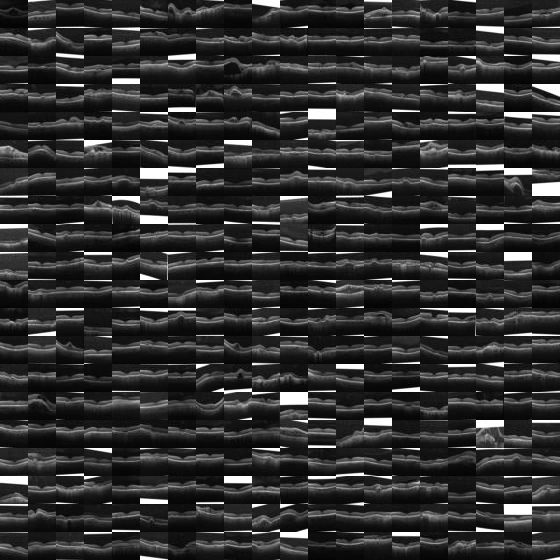

In [14]:
trainDataset.montage(length = 20)

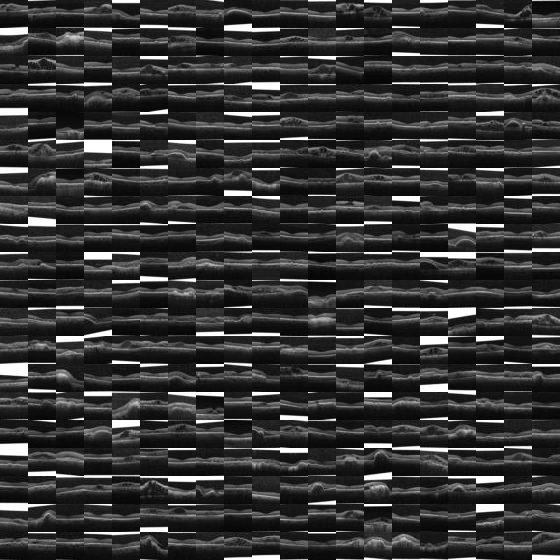

In [15]:
testDataset.montage(length = 20)

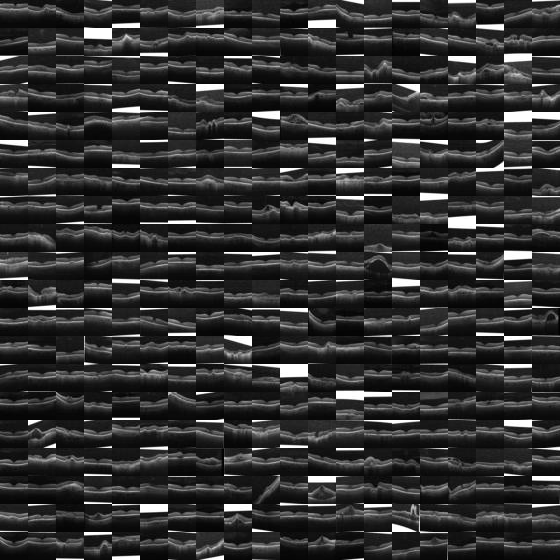

In [16]:
validDataset.montage(length = 20)

In [17]:
lr=0.01
num_epochs = 50
earlyStopPatience = 10
lrsPatience = 5

In [18]:
class ModelTrial():
    def __init__(self, model, criterion, optimizer, scheduler, l1_lambda):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.train_time = None
        self.epochs = []
        self.test_outputs = {}
        self.softmax = nn.Softmax(dim = 1)
        self.l1_lambda = l1_lambda
    def printModel(self):
        print(self.model)
    def printModelSummary(self, batch_size = 32):
        print(torchinfo.summary(self.model, input_size = (batch_size, self.model.in_channels_count, self.model.in_features_count, self.model.in_features_count)))
    def trainingLoop(self, trainLoader, validationLoader, num_epochs, tempStorePath, verbose = True, patience = 10):
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.test_outputs = {}
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        min_validation_loss = float('inf')
        patience_ctr = 0
        break_epoch = self.epochs[-1]
        for epoch in self.epochs:
            print(f"In Epoch {epoch}")
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for batch_idx, (inputs, labels) in enumerate(tqdm(trainLoader)):
                inputs = inputs.to(device)
                labels = labels.to(device).flatten().long()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = torch.max(self.softmax(outputs), 1).indices
                loss = self.criterion(outputs, labels)
                l1_reg = torch.tensor(0., requires_grad=True)
                for param in self.model.parameters():
                    l1_reg = l1_reg + torch.norm(param, 1)

                loss = loss + self.l1_lambda * l1_reg

                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for batch_idx, (inputs, labels) in enumerate(tqdm(validationLoader)):
                    inputs = inputs.to(device)
                    labels = labels.to(device).flatten().long()
                    outputs = self.model(inputs)
                    y_pred = torch.max(self.softmax(outputs), 1).indices
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()

                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
            self.scheduler.step(validation_loss)
            if validation_loss <= min_validation_loss:
                min_validation_loss = validation_loss
                patience_counter = 0
                self.saveModel(tempStorePath)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("\nEarly stopping")
                    break_epoch = epoch
                    break
        self.epochs = self.epochs[:break_epoch]
        self.train_time = cumulative_train_time
        self.loadModel(tempStorePath)
        print("Training Ended !!!")

    def testDatasetPass(self, testLoader):
        self.model.eval()
        test_loss = 0.0
        test_correct = 0
        test_labels = torch.Tensor([]).to(device)
        test_pred = torch.Tensor([]).to(device)
        test_outputs = torch.Tensor([]).to(device)
        print(f"Testing Started!")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(tqdm(testLoader)):
                inputs = inputs.to(device)
                labels = labels.to(device).flatten().long()
                outputs = self.model(inputs)
                y_pred = torch.max(self.softmax(outputs), 1).indices
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)
                test_correct += (y_pred == labels).sum().item()
                test_labels = torch.cat((test_labels,labels),dim = 0)
                test_pred = torch.cat((test_pred,y_pred), dim = 0)
                test_outputs = torch.cat((test_outputs,self.softmax(outputs)), dim = 0)

        test_accuracy = 100 * test_correct / test_dataset_size
        self.test_metrics['accuracy'] = [test_accuracy]*(len(self.epochs))
        self.test_metrics['loss'] = [test_loss]*(len(self.epochs))
        self.test_outputs['accuracy'] = test_accuracy
        self.test_outputs['labels'] = test_labels
        self.test_outputs['y_pred'] = test_pred
        self.test_outputs['outputs'] = test_outputs
        print(f"Testing Completed!!")
        print(f"Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")

    def printTrainTimeStatistics(self):
        print("Time taken to train model (train phase alone considered) is : ")
        days = self.train_time.days
        seconds = self.train_time.seconds
        microseconds = self.train_time.microseconds
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Days: {days}, Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Microseconds: {microseconds}")

    def plotLossVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.plot(self.epochs, self.test_metrics['loss'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['loss'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['loss'], label = 'Train')

        plt.title('Loss vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def plotAccuracyVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.plot(self.epochs, self.test_metrics['accuracy'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['accuracy'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['accuracy'], label = 'Train')

        plt.title('Accuracy vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def printMetrics(self):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true = self.test_outputs['labels'].cpu().numpy(), y_pred = self.test_outputs['y_pred'].cpu().numpy(), average=None,labels=[float(i) for i in range(self.model.out_features_count)])
        print(f"Accuracy for Test Dataset at end of training : {self.test_outputs['accuracy']:.5f}")
        for class_label, precision, recall, fscore in zip(range(len(precision)), precision, recall, fscore):
            print(f"For Class {num_to_label[class_label]}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={fscore:.4f}")

    def plotConfusionMatrix(self):
        bcm = MulticlassConfusionMatrix(self.model.out_features_count).to(device)
        bcm.update(self.test_outputs['y_pred'], self.test_outputs['labels'])
        fig, ax = plt.subplots()
        bcm.plot(ax = ax)
        plt.title('Confusion Matrix for Test Dataset')
        plt.plot()

    def plotROCgraph(self):
        ROC = MulticlassROC(self.model.out_features_count)
        ROC.update(self.test_outputs['outputs'], self.test_outputs['labels'].type(torch.int64))
        fig, ax = plt.subplots()
        ROC.plot(score=True, ax = ax)
        plt.title('ROC Curve for Test Dataset')
        plt.show()

    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)

    def loadModel(self, path):
        loadedModel = torch.load(path)
        self.model.load_state_dict(loadedModel)

In [19]:
class CNNet(nn.Module):
    def __init__(self, inputChannels, imageDim, numClasses, dropoutProb):
        super(CNNet, self).__init__()
        self.in_channels_count = inputChannels
        self.in_features_count = imageDim
        self.out_features_count = numClasses
        self.conv1 = nn.Conv2d(in_channels = self.in_channels_count, out_channels = 16, kernel_size = 3, padding = 1, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, stride = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.batchnorm2d1 = nn.BatchNorm2d(16)
        self.batchnorm2d2 = nn.BatchNorm2d(64)
        self.batchnorm2d3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(p = dropoutProb)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, self.out_features_count)
    def forward(self, x):
        x = nnF.relu(self.conv1(x))
        x = self.pool1(nnF.relu(self.batchnorm2d1(self.conv4(x))))
        x = self.pool1(nnF.relu(self.batchnorm2d2(self.conv2(x))))
        x = self.pool1(nnF.relu(self.batchnorm2d3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = nnF.relu(self.fc1(x))
        x = self.dropout(x)
        x = nnF.relu(self.fc2(x))
        x = self.dropout(x)
        x = nnF.relu(self.fc3(x))
        x = nnF.relu(self.fc4(x))
        return x

In [20]:
cnNet = CNNet(inputChannels = 1, imageDim = 32, numClasses = num_classes, dropoutProb = 0.25)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnNet.parameters(), lr = lr, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [21]:
cnnModel = ModelTrial(cnNet, criterion, optimizer, scheduler, l1_lambda = 1e-6)

In [22]:
cnnModel.printModel()

CNNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (batchnorm2d1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


In [23]:
cnnModel.printModelSummary(batch_size = batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
CNNet                                    [128, 4]                  --
├─Conv2d: 1-1                            [128, 16, 32, 32]         160
├─Conv2d: 1-2                            [128, 16, 32, 32]         2,320
├─BatchNorm2d: 1-3                       [128, 16, 32, 32]         32
├─MaxPool2d: 1-4                         [128, 16, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         9,280
├─BatchNorm2d: 1-6                       [128, 64, 16, 16]         128
├─MaxPool2d: 1-7                         [128, 64, 8, 8]           --
├─Conv2d: 1-8                            [128, 128, 8, 8]          73,856
├─BatchNorm2d: 1-9                       [128, 128, 8, 8]          256
├─MaxPool2d: 1-10                        [128, 128, 4, 4]          --
├─Linear: 1-11                           [128, 512]                1,049,088
├─Dropout: 1-12                          [128, 512]              

In [24]:
cnnModel.trainingLoop(trainLoader, validationLoader, num_epochs = num_epochs, tempStorePath = "/content/drive/MyDrive/UB/DL/Assignment0/temp.pth", verbose = True, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 762/762 [00:10<00:00, 72.72it/s]


Epoch 1, Training Loss: 0.85251, Training Accuracy: 68.95%


100%|██████████| 85/85 [00:01<00:00, 75.67it/s]


Epoch 1, Validation Loss: 1.39779, Validation Accuracy: 41.39%
In Epoch 2


100%|██████████| 762/762 [00:09<00:00, 77.71it/s]


Epoch 2, Training Loss: 0.55619, Training Accuracy: 81.54%


100%|██████████| 85/85 [00:01<00:00, 74.47it/s]


Epoch 2, Validation Loss: 0.68463, Validation Accuracy: 78.46%
In Epoch 3


100%|██████████| 762/762 [00:09<00:00, 76.28it/s]


Epoch 3, Training Loss: 0.46670, Training Accuracy: 84.57%


100%|██████████| 85/85 [00:01<00:00, 73.24it/s]


Epoch 3, Validation Loss: 0.47745, Validation Accuracy: 84.22%
In Epoch 4


100%|██████████| 762/762 [00:10<00:00, 71.82it/s]


Epoch 4, Training Loss: 0.42892, Training Accuracy: 85.87%


100%|██████████| 85/85 [00:01<00:00, 75.28it/s]


Epoch 4, Validation Loss: 0.45984, Validation Accuracy: 84.98%
In Epoch 5


100%|██████████| 762/762 [00:09<00:00, 80.48it/s]


Epoch 5, Training Loss: 0.40037, Training Accuracy: 86.75%


100%|██████████| 85/85 [00:01<00:00, 72.92it/s]


Epoch 5, Validation Loss: 0.36378, Validation Accuracy: 87.80%
In Epoch 6


100%|██████████| 762/762 [00:09<00:00, 77.24it/s]


Epoch 6, Training Loss: 0.37676, Training Accuracy: 87.56%


100%|██████████| 85/85 [00:01<00:00, 74.15it/s]


Epoch 6, Validation Loss: 0.38803, Validation Accuracy: 86.64%
In Epoch 7


100%|██████████| 762/762 [00:09<00:00, 80.89it/s]


Epoch 7, Training Loss: 0.35607, Training Accuracy: 88.21%


100%|██████████| 85/85 [00:01<00:00, 78.32it/s]


Epoch 7, Validation Loss: 0.40077, Validation Accuracy: 86.48%
In Epoch 8


100%|██████████| 762/762 [00:09<00:00, 77.40it/s]


Epoch 8, Training Loss: 0.33865, Training Accuracy: 88.86%


100%|██████████| 85/85 [00:01<00:00, 79.27it/s]


Epoch 8, Validation Loss: 0.44676, Validation Accuracy: 85.17%
In Epoch 9


100%|██████████| 762/762 [00:09<00:00, 79.87it/s]


Epoch 9, Training Loss: 0.32336, Training Accuracy: 89.33%


100%|██████████| 85/85 [00:01<00:00, 79.04it/s]


Epoch 9, Validation Loss: 0.47871, Validation Accuracy: 85.09%
In Epoch 10


100%|██████████| 762/762 [00:09<00:00, 79.78it/s]


Epoch 10, Training Loss: 0.31111, Training Accuracy: 89.79%


100%|██████████| 85/85 [00:01<00:00, 79.27it/s]


Epoch 10, Validation Loss: 0.31869, Validation Accuracy: 88.84%
In Epoch 11


100%|██████████| 762/762 [00:09<00:00, 77.70it/s]


Epoch 11, Training Loss: 0.30168, Training Accuracy: 90.07%


100%|██████████| 85/85 [00:01<00:00, 74.15it/s]


Epoch 11, Validation Loss: 0.36427, Validation Accuracy: 87.14%
In Epoch 12


100%|██████████| 762/762 [00:09<00:00, 77.79it/s]


Epoch 12, Training Loss: 0.29069, Training Accuracy: 90.40%


100%|██████████| 85/85 [00:01<00:00, 73.14it/s]


Epoch 12, Validation Loss: 0.28710, Validation Accuracy: 89.96%
In Epoch 13


100%|██████████| 762/762 [00:10<00:00, 72.34it/s]


Epoch 13, Training Loss: 0.28267, Training Accuracy: 90.77%


100%|██████████| 85/85 [00:01<00:00, 73.92it/s]


Epoch 13, Validation Loss: 0.29719, Validation Accuracy: 89.92%
In Epoch 14


100%|██████████| 762/762 [00:09<00:00, 76.47it/s]


Epoch 14, Training Loss: 0.27218, Training Accuracy: 91.14%


100%|██████████| 85/85 [00:01<00:00, 76.92it/s]


Epoch 14, Validation Loss: 0.33258, Validation Accuracy: 88.16%
In Epoch 15


100%|██████████| 762/762 [00:09<00:00, 78.47it/s]


Epoch 15, Training Loss: 0.26594, Training Accuracy: 91.37%


100%|██████████| 85/85 [00:01<00:00, 79.17it/s]


Epoch 15, Validation Loss: 0.31843, Validation Accuracy: 88.58%
In Epoch 16


100%|██████████| 762/762 [00:09<00:00, 76.51it/s]


Epoch 16, Training Loss: 0.25925, Training Accuracy: 91.69%


100%|██████████| 85/85 [00:01<00:00, 78.40it/s]


Epoch 16, Validation Loss: 0.28434, Validation Accuracy: 90.43%
In Epoch 17


100%|██████████| 762/762 [00:10<00:00, 70.86it/s]


Epoch 17, Training Loss: 0.25326, Training Accuracy: 91.85%


100%|██████████| 85/85 [00:01<00:00, 78.30it/s]


Epoch 17, Validation Loss: 0.30377, Validation Accuracy: 89.06%
In Epoch 18


100%|██████████| 762/762 [00:09<00:00, 81.17it/s]


Epoch 18, Training Loss: 0.24538, Training Accuracy: 92.02%


100%|██████████| 85/85 [00:01<00:00, 72.94it/s]


Epoch 18, Validation Loss: 0.48590, Validation Accuracy: 85.91%
In Epoch 19


100%|██████████| 762/762 [00:09<00:00, 81.77it/s]


Epoch 19, Training Loss: 0.24075, Training Accuracy: 92.25%


100%|██████████| 85/85 [00:01<00:00, 72.16it/s]


Epoch 19, Validation Loss: 0.26551, Validation Accuracy: 91.05%
In Epoch 20


100%|██████████| 762/762 [00:09<00:00, 77.49it/s]


Epoch 20, Training Loss: 0.23522, Training Accuracy: 92.45%


100%|██████████| 85/85 [00:01<00:00, 75.88it/s]


Epoch 20, Validation Loss: 0.25263, Validation Accuracy: 91.43%
In Epoch 21


100%|██████████| 762/762 [00:10<00:00, 74.11it/s]


Epoch 21, Training Loss: 0.22761, Training Accuracy: 92.72%


100%|██████████| 85/85 [00:01<00:00, 73.08it/s]


Epoch 21, Validation Loss: 0.33964, Validation Accuracy: 89.20%
In Epoch 22


100%|██████████| 762/762 [00:09<00:00, 77.91it/s]


Epoch 22, Training Loss: 0.22401, Training Accuracy: 92.90%


100%|██████████| 85/85 [00:01<00:00, 78.08it/s]


Epoch 22, Validation Loss: 0.28704, Validation Accuracy: 89.84%
In Epoch 23


100%|██████████| 762/762 [00:09<00:00, 80.94it/s]


Epoch 23, Training Loss: 0.21789, Training Accuracy: 93.10%


100%|██████████| 85/85 [00:01<00:00, 75.30it/s]


Epoch 23, Validation Loss: 0.31970, Validation Accuracy: 89.05%
In Epoch 24


100%|██████████| 762/762 [00:11<00:00, 66.26it/s]


Epoch 24, Training Loss: 0.21306, Training Accuracy: 93.16%


100%|██████████| 85/85 [00:01<00:00, 72.65it/s]


Epoch 24, Validation Loss: 0.27783, Validation Accuracy: 90.61%
In Epoch 25


100%|██████████| 762/762 [00:09<00:00, 78.12it/s]


Epoch 25, Training Loss: 0.20907, Training Accuracy: 93.41%


100%|██████████| 85/85 [00:01<00:00, 78.25it/s]


Epoch 25, Validation Loss: 0.39459, Validation Accuracy: 87.52%
In Epoch 26


100%|██████████| 762/762 [00:09<00:00, 78.46it/s]


Epoch 26, Training Loss: 0.20406, Training Accuracy: 93.53%


100%|██████████| 85/85 [00:01<00:00, 77.16it/s]


Epoch 26, Validation Loss: 0.57311, Validation Accuracy: 76.79%
In Epoch 27


100%|██████████| 762/762 [00:09<00:00, 77.11it/s]


Epoch 27, Training Loss: 0.16841, Training Accuracy: 94.94%


100%|██████████| 85/85 [00:01<00:00, 79.57it/s]


Epoch 27, Validation Loss: 0.23234, Validation Accuracy: 92.68%
In Epoch 28


100%|██████████| 762/762 [00:09<00:00, 79.14it/s]


Epoch 28, Training Loss: 0.16145, Training Accuracy: 95.20%


100%|██████████| 85/85 [00:01<00:00, 77.17it/s]


Epoch 28, Validation Loss: 0.23158, Validation Accuracy: 92.72%
In Epoch 29


100%|██████████| 762/762 [00:09<00:00, 78.89it/s]


Epoch 29, Training Loss: 0.15950, Training Accuracy: 95.24%


100%|██████████| 85/85 [00:01<00:00, 76.47it/s]


Epoch 29, Validation Loss: 0.23106, Validation Accuracy: 92.60%
In Epoch 30


100%|██████████| 762/762 [00:09<00:00, 76.93it/s]


Epoch 30, Training Loss: 0.15597, Training Accuracy: 95.45%


100%|██████████| 85/85 [00:01<00:00, 77.90it/s]


Epoch 30, Validation Loss: 0.23631, Validation Accuracy: 92.72%
In Epoch 31


100%|██████████| 762/762 [00:09<00:00, 77.80it/s]


Epoch 31, Training Loss: 0.15370, Training Accuracy: 95.51%


100%|██████████| 85/85 [00:01<00:00, 68.61it/s]


Epoch 31, Validation Loss: 0.23198, Validation Accuracy: 92.58%
In Epoch 32


100%|██████████| 762/762 [00:10<00:00, 75.59it/s]


Epoch 32, Training Loss: 0.15328, Training Accuracy: 95.40%


100%|██████████| 85/85 [00:01<00:00, 76.02it/s]


Epoch 32, Validation Loss: 0.22826, Validation Accuracy: 92.62%
In Epoch 33


100%|██████████| 762/762 [00:09<00:00, 78.75it/s]


Epoch 33, Training Loss: 0.15139, Training Accuracy: 95.55%


100%|██████████| 85/85 [00:01<00:00, 71.63it/s]


Epoch 33, Validation Loss: 0.23479, Validation Accuracy: 92.65%
In Epoch 34


100%|██████████| 762/762 [00:09<00:00, 79.04it/s]


Epoch 34, Training Loss: 0.14943, Training Accuracy: 95.61%


100%|██████████| 85/85 [00:01<00:00, 72.50it/s]


Epoch 34, Validation Loss: 0.23264, Validation Accuracy: 92.68%
In Epoch 35


100%|██████████| 762/762 [00:09<00:00, 77.90it/s]


Epoch 35, Training Loss: 0.14844, Training Accuracy: 95.67%


100%|██████████| 85/85 [00:01<00:00, 75.58it/s]


Epoch 35, Validation Loss: 0.22977, Validation Accuracy: 92.62%
In Epoch 36


100%|██████████| 762/762 [00:09<00:00, 79.85it/s]


Epoch 36, Training Loss: 0.14758, Training Accuracy: 95.65%


100%|██████████| 85/85 [00:01<00:00, 71.55it/s]


Epoch 36, Validation Loss: 0.23143, Validation Accuracy: 92.49%
In Epoch 37


100%|██████████| 762/762 [00:10<00:00, 75.34it/s]


Epoch 37, Training Loss: 0.14640, Training Accuracy: 95.72%


100%|██████████| 85/85 [00:01<00:00, 72.27it/s]


Epoch 37, Validation Loss: 0.23179, Validation Accuracy: 92.49%
In Epoch 38


100%|██████████| 762/762 [00:09<00:00, 76.61it/s]


Epoch 38, Training Loss: 0.14440, Training Accuracy: 95.79%


100%|██████████| 85/85 [00:01<00:00, 75.25it/s]


Epoch 38, Validation Loss: 0.23311, Validation Accuracy: 92.70%
In Epoch 39


100%|██████████| 762/762 [00:10<00:00, 74.90it/s]


Epoch 39, Training Loss: 0.13962, Training Accuracy: 96.02%


100%|██████████| 85/85 [00:01<00:00, 70.04it/s]


Epoch 39, Validation Loss: 0.23009, Validation Accuracy: 92.64%
In Epoch 40


100%|██████████| 762/762 [00:09<00:00, 77.09it/s]


Epoch 40, Training Loss: 0.13998, Training Accuracy: 95.98%


100%|██████████| 85/85 [00:01<00:00, 79.01it/s]


Epoch 40, Validation Loss: 0.23080, Validation Accuracy: 92.66%
In Epoch 41


100%|██████████| 762/762 [00:09<00:00, 77.73it/s]


Epoch 41, Training Loss: 0.14023, Training Accuracy: 95.98%


100%|██████████| 85/85 [00:01<00:00, 79.61it/s]


Epoch 41, Validation Loss: 0.23064, Validation Accuracy: 92.63%
In Epoch 42


100%|██████████| 762/762 [00:09<00:00, 76.67it/s]


Epoch 42, Training Loss: 0.13977, Training Accuracy: 96.00%


100%|██████████| 85/85 [00:01<00:00, 76.60it/s]

Epoch 42, Validation Loss: 0.23103, Validation Accuracy: 92.61%

Early stopping
Training Ended !!!


In [26]:
cnnModel.printTrainTimeStatistics() #Note: This was on faster GPU

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 6, Seconds: 55, Microseconds: 736544


In [27]:
cnnModel.testDatasetPass(testLoader)

Testing Started!


100%|██████████| 8/8 [00:00<00:00, 39.78it/s]

Testing Completed!!
Testing Loss: 0.80980, Testing Accuracy: 76.40%


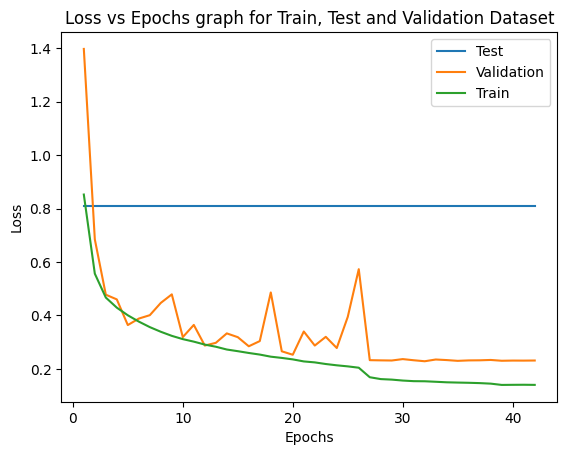

In [28]:
cnnModel.plotLossVsEpochs()

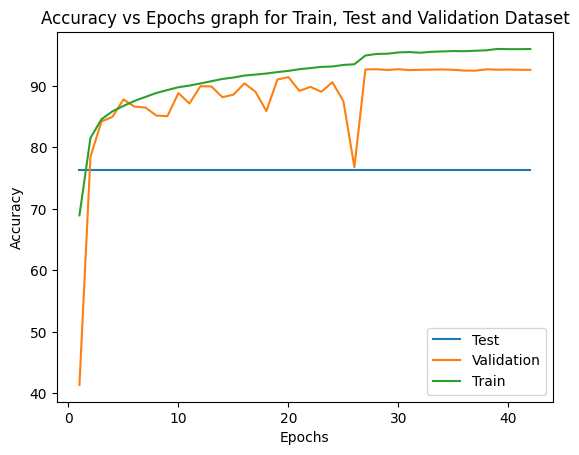

In [29]:
cnnModel.plotAccuracyVsEpochs()

In [30]:
cnnModel.printMetrics()

Accuracy for Test Dataset at end of training : 76.40000
For Class choroidal neovascularization: Precision=0.6256, Recall=0.9760, F1 Score=0.7625
For Class diabetic macular edema: Precision=0.9182, Recall=0.8080, F1 Score=0.8596
For Class drusen: Precision=0.8824, Recall=0.3600, F1 Score=0.5114
For Class normal: Precision=0.7917, Recall=0.9120, F1 Score=0.8476


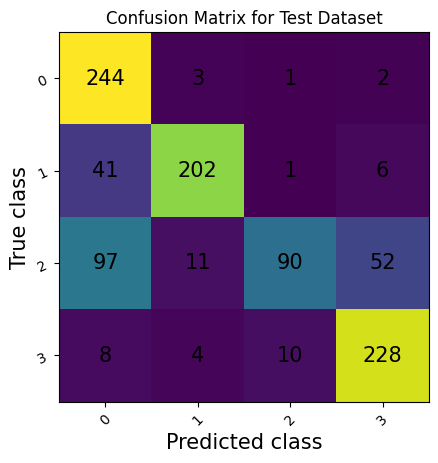

In [31]:
cnnModel.plotConfusionMatrix()

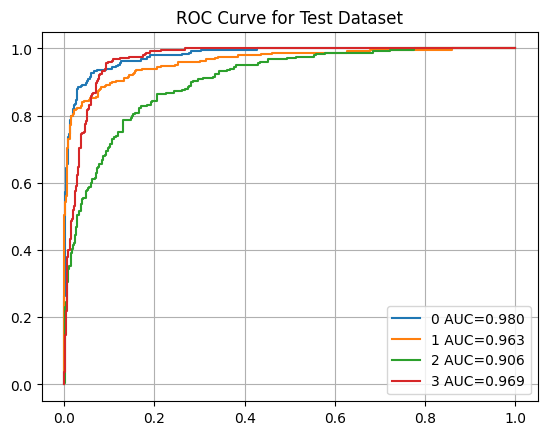

In [32]:
cnnModel.plotROCgraph()

#### References
1) https://docs.python.org/3/index.html

2) https://matplotlib.org/stable/

3) https://seaborn.pydata.org/api.html

4) https://pandas.pydata.org/docs/reference/index.html

5) https://numpy.org/doc/stable/index.html

6) https://pytorch.org/docs/stable/index.html

7) https://github.com/TylerYep/torchinfo#readme

8) https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

9) https://torchmetrics.readthedocs.io/en/stable/

10) https://scikit-learn.org/stable/modules/classes.html

11) https://github.com/MedMNIST/MedMNIST/tree/main

12) https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb